
# Multi-objective Bayesian Optimization


TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [ ]:
%reset -f
import numpy as np

import torch
from xopt import XoptBase, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

import pandas as pd

evaluator = Evaluator(evaluate_TNK)

generator = MOBOGenerator(tnk_vocs, n_initial=10, proximal_lengthscales=[1.0,1.0])
X = XoptBase(generator=generator, evaluator=evaluator, vocs=tnk_vocs)
X.step()

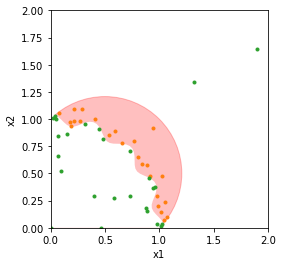

In [4]:

fig,ax = plt.subplots()

theta = np.linspace(0,np.pi/2)
r = np.sqrt(1 + 0.1*np.cos(16*theta))
x_1 = r*np.sin(theta)
x_2_lower = r*np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5)**2)**0.5 + 0.5

z = np.zeros_like(x_1)

#ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc='white')
circle = plt.Circle((0.5, 0.5), 0.5**0.5,
                    color='r', alpha=0.25, zorder=0,
                    label='Valid Region')
ax.add_patch(circle)
history = pd.concat([X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False)

ax.plot(*history[["x1","x2"]][history["feasible"]].to_numpy().T,'.C1')
ax.plot(*history[["x1","x2"]][~history["feasible"]].to_numpy().T,'.C2')

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_aspect('equal')